In [6]:
import numpy as np
import pandas as pd
from spatial_OT.OT import *
from spatial_OT.utils import *
from scipy.spatial import distance
import numpy as np
import scanpy as sc
import anndata as ad
import ot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
sample = 'E1z2'

scdata = pd.read_csv('../Mouse_simulations/mousedata_2020/' + sample + '/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('../Mouse_simulations/mousedata_2020/' + sample + '/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('../Mouse_simulations/mousedata_2020/' + sample + '/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('../Mouse_simulations/mousedata_2020/' + sample + '/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('../Mouse_simulations/mousedata_2020/' + sample + '/metadata.csv',index_col=0)

adata = sc.AnnData(scdata, obs=scmetadata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor
stadata.obsm["spatial"] = stadata.obsm["spatial"].values

In [8]:
adata, stadata

(AnnData object with n_obs × n_vars = 10150 × 351
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 581 × 351
     obsm: 'spatial')

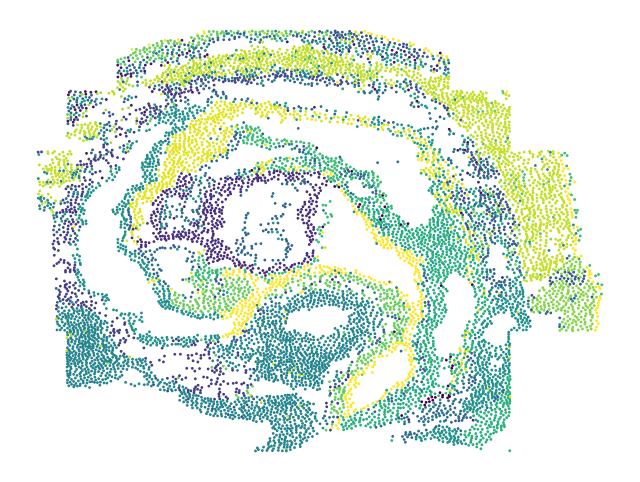

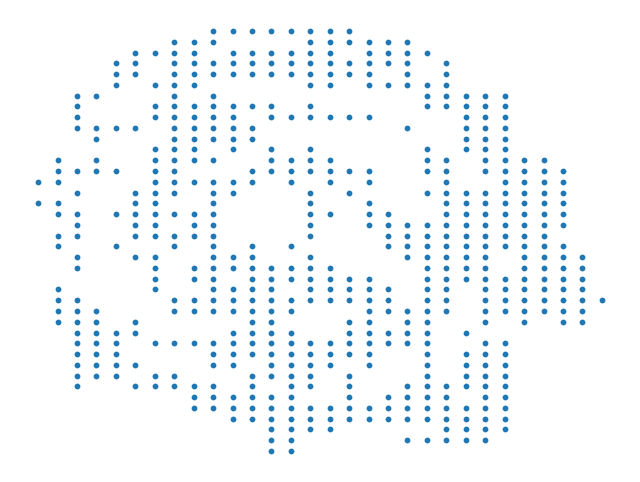

In [9]:
adata.obs['celltype_mapped'] = pd.Categorical(adata.obs['celltype_mapped_refined']).codes
plt.figure(figsize=(8, 6))
plt.scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1], c=adata.obs['celltype_mapped'], s=1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove axis ticks (optional)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(stadata.obsm['spatial'][:,0], stadata.obsm['spatial'][:,1], s=10)
# Remove axis borders (spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove axis ticks (optional)
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
n_comp = 30
common_genes = adata.var.index.intersection(stadata.var.index)
# Subset the AnnData objects based on common genes
adata = adata[:, common_genes].copy() 
stadata = stadata[:, common_genes].copy()
joint_adata = ad.concat([adata, stadata], axis=0)

# Concatenate the AnnData objects
sc.pp.normalize_total(joint_adata)
sc.pp.log1p(joint_adata)
sc.pp.pca(joint_adata, n_comp)
joint_datamatrix = joint_adata.obsm['X_pca']
X = joint_datamatrix[:adata.shape[0], :]
Y = joint_datamatrix[adata.shape[0]:, :]

In [11]:
X_df = pd.DataFrame(X)
cell_types = adata.obs['celltype_mapped_refined']
k = 10
print (f"Building k-NN graph for SC using expression with k = {k}")
G1 = build_knn_graph_expression(X_df, cell_types, k=k)
print(f"Average graph degree: {round(np.mean([d for n, d in G1.degree()]),3)}")
slice1_average = compute_average_neighbor_expression(G1, pd.DataFrame(X))
slice_1_entropy = compute_spatial_entropy(G1)

Building k-NN graph for SC using expression with k = 10
Average graph degree: 15.86


In [12]:
coords = pd.DataFrame(stadata.obsm["spatial"], columns=["x", "y"])
Y_df = pd.DataFrame(Y)
Y_df["x"] = coords["x"].values
Y_df["y"] = coords["y"].values

print (f"Building k-NN graph for spatial data using locations with k = {k}")
G2 = build_knn_graph_proportions(Y_df, stgtcelltype, k=k)
print(f"Average graph degree: {round(np.mean([d for n, d in G2.degree()]),3)}")
slice2_average = compute_average_neighbor_expression(G2, pd.DataFrame(Y))
slice_2_entropy = compute_spatial_entropy_with_proportions(G2)

Building k-NN graph for spatial data using locations with k = 10
Average graph degree: 11.336


In [13]:
M = distance.cdist(X, Y)
C1 = distance.cdist(X, X)
C2 = distance.cdist(stadata.obsm["spatial"], stadata.obsm["spatial"])

slice_1_entropy_array = np.array(list(slice_1_entropy.values()))
slice_2_entropy_array = np.array(list(slice_2_entropy.values()))
C3 = np.abs(slice_1_entropy_array[:, np.newaxis] - slice_2_entropy_array[np.newaxis, :])

C4 = distance.cdist(slice1_average.values, slice2_average.values)

C1 = C1.astype(float)
C2 = C2.astype(float)
M = M.astype(float)

print ("Shape of the matrices C1, C2, C3, C4, M:")
print (C1.shape, C2.shape, C3.shape, C4.shape, M.shape)

M /= M.max()
C1 /= C1.max()
C2 /= C2.max()
C3 /= C3.max()
C4 /= C4.max()
print ("Matrices normalized!")

Shape of the matrices C1, C2, C3, C4, M:
(10150, 10150) (581, 581) (10150, 581) (10150, 581) (10150, 581)
Matrices normalized!


In [14]:
p = ot.unif(X.shape[0])
q = ot.unif(Y.shape[0])
alpha = 0.8

G0 = np.outer(p, q)
epsilon = 0.001

FGW_T = compute_transport(G0, epsilon, alpha, C1, C2, p, q, M)
single_cell_coords_normal = assign_coordinates(FGW_T, coords)

In [15]:
G0 = np.outer(p, q)

FGW_SN = compute_transport(G0, epsilon, alpha, C1, C2, p, q, M, C3, C4)
single_cell_coords = assign_coordinates(FGW_SN, coords)

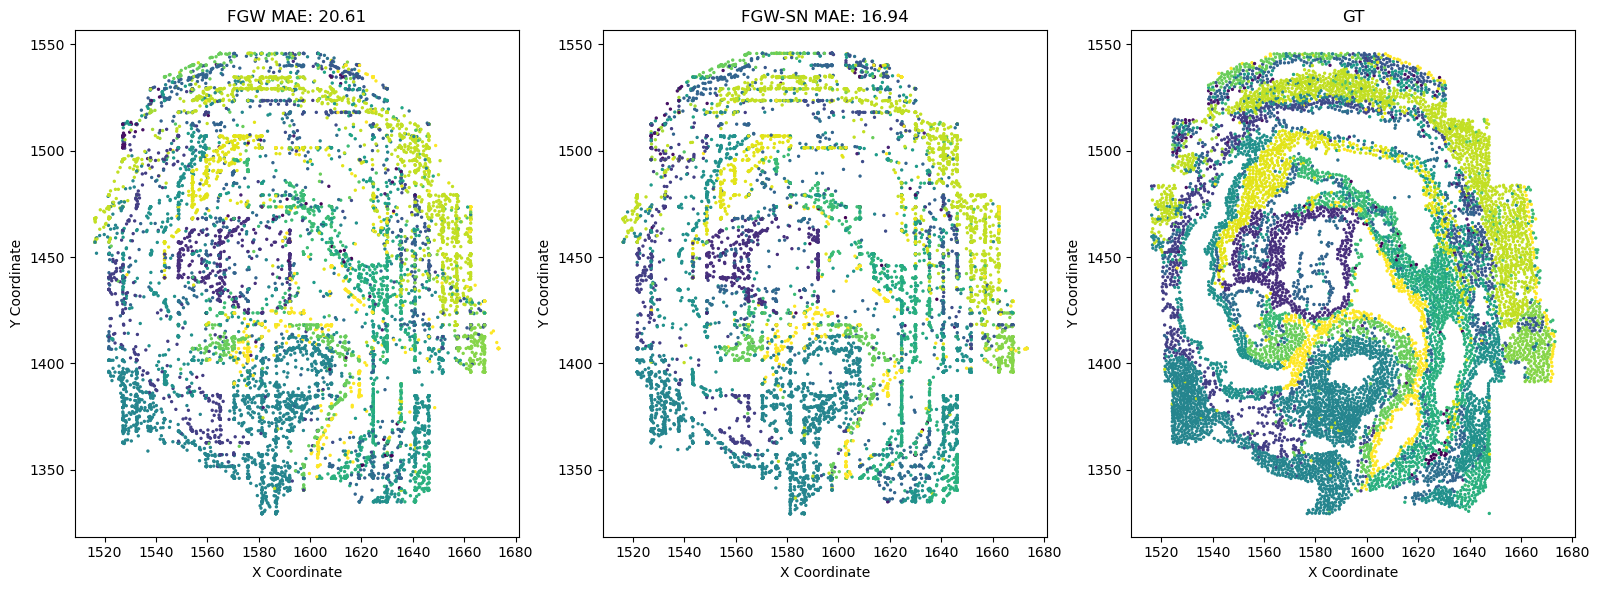

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# First plot
axes[0].scatter(single_cell_coords_normal["x"], single_cell_coords_normal["y"], c=adata.obs['celltype_mapped'], s=2)
axes[0].set_title("FGW MAE: " + str(round(compute_mae(np.array(single_cell_coords_normal), adata.obsm['spatial']), 2)))
axes[0].set_xlabel("X Coordinate")
axes[0].set_ylabel("Y Coordinate")

# Second plot
axes[1].scatter(single_cell_coords["x"], single_cell_coords["y"], c=adata.obs['celltype_mapped'], s=2)
axes[1].set_title("FGW-SN MAE: " + str(round(compute_mae(np.array(single_cell_coords), adata.obsm['spatial']), 2)))
axes[1].set_xlabel("X Coordinate")
axes[1].set_ylabel("Y Coordinate")

axes[2].scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1], c=adata.obs['celltype_mapped'], s=2)
axes[2].set_title("GT")
axes[2].set_xlabel("X Coordinate")
axes[2].set_ylabel("Y Coordinate")

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
from scipy.stats import pearsonr
corr_coefficient, p_value = pearsonr(np.array(single_cell_coords_normal).flatten(), adata.obsm['spatial'].flatten())
print(f"Pearson Correlation FGW: {corr_coefficient:.4f}")

corr_coefficient, p_value = pearsonr(np.array(single_cell_coords).flatten(), adata.obsm['spatial'].flatten())
print(f"Pearson Correlation FGW-SN: {corr_coefficient:.4f}")


Pearson Correlation FGW: 0.9714
Pearson Correlation FGW-SN: 0.9804
